# Density Prediction

Notebook to use the Murphy et al. [2024] density model to generate predictions. 

[Model Fitting](./RF_model.ipynb) is done here and saved into a pickle file. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec

import cartopy.crs as ccrs

In [3]:
pth = '../'
sys.path.append(os.path.dirname(pth))

In [4]:
from mltdm.den_fx import fx_den

In [5]:
# initiate the random forest density object
# this sets up the grids for predicting density
# two grids are intitated
# 1) MLT grid
# 2) Geographic grid
# When initiating you can also change the 
# grid dimension by specifing
# n_lat - number of latitude bins
# n_mlt - number of magnetic local time bins
rf_mod = fx_den(dropAE=True)


Loading fx_den_noAE_bz2.skops, this will take a few minutes.


# Model Variations

The fixed altitude model has two variations. One which uses AE and one that doesn't. By default the model which **doesn't** use AE is loaded to derive predictions. This is because AE is no longer a reliable index which can be retrieved in real or near-real time. 


In [6]:
assert rf_mod.AE == False
print(rf_mod.feat_cols)

['1300_02', '43000_09', '85550_13', '94400_18', 'SYM_H index']


# Polar MLT plots

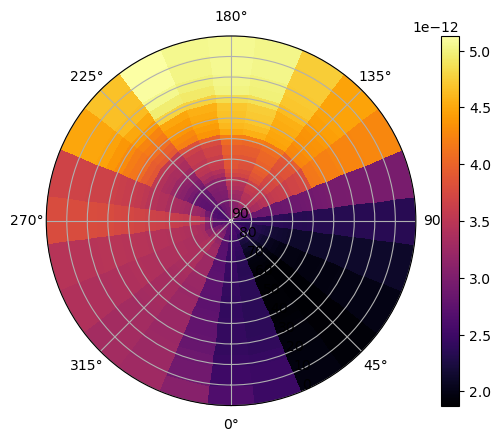

In [7]:
# predict density on the mlt grid
# you can predict density for a single time point over the entire grid
# or a date range over the entire grid
denMLT = rf_mod.pred_den_mlt(sdate='2003-01-01 00:00', edate='2003-01-01 00:20')

# plot the denisty
# if no date is passed the first date is plotted
rf_mod.plot_dpolar(denMLT,cmap=plt.cm.inferno)


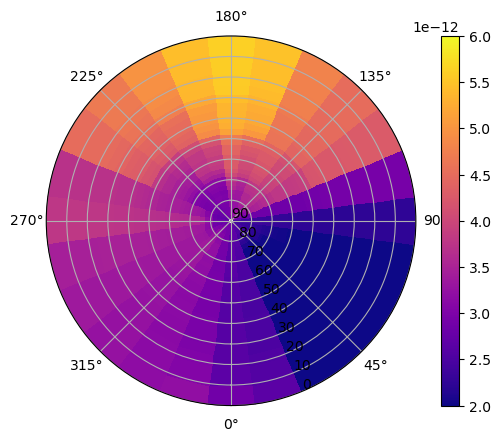

In [8]:
# plot the density for a specifc time from the previously prediction call
# use vmin and vmax to set the color scale range 
# and change the color map
rf_mod.plot_dpolar(denMLT,cmap=plt.cm.plasma, date='2003-01-01 00:15', vmin=2E-12, vmax=6E-12)

# Geographic Plots

In [9]:
# predict density on a geographic grid
# over a 3 day period

denGeo = rf_mod.pred_den_geo(sdate='2003-01-01 00:00:00', edate='2003-01-03 00:00:00')

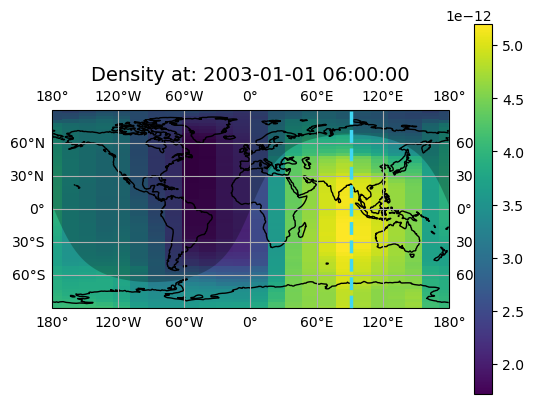

In [10]:
# plot the density at specific time on the created figure
fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection=ccrs.PlateCarree())
rf_mod.plot_dgeo(denGeo, ax=ax2, date='2003-01-01 06:00:00')

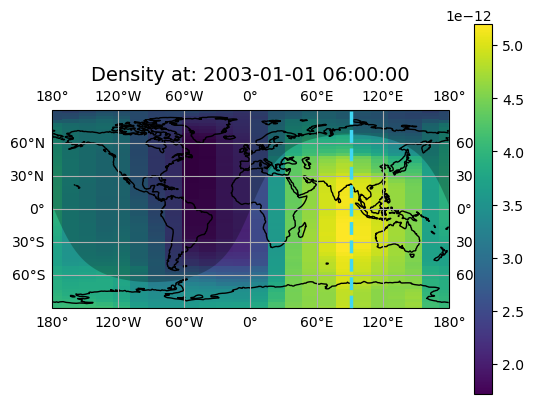

In [11]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111,projection=ccrs.PlateCarree())
rf_mod.plot_dgeo(denGeo, ax=ax2, date='2003-01-01 06:00:00')

# Combine Plots using Grid Spec

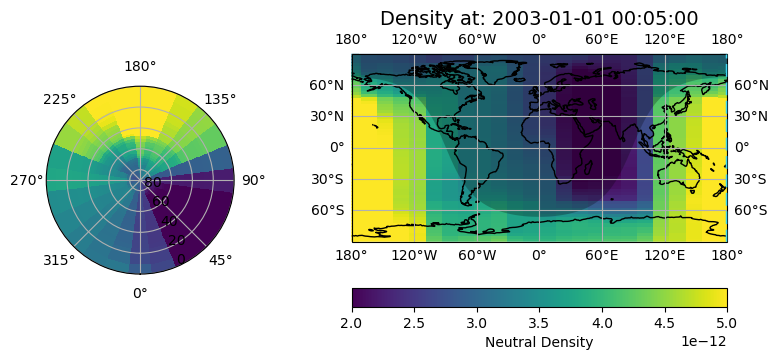

In [12]:
date = '2003-01-01 00:05:00'
vmin = 2E-12
vmax = 5E-12

fig = plt.figure(figsize=(10,4))

gs = GridSpec(1, 2, width_ratios=[1, 2])
ax1 = fig.add_subplot(gs[0], projection='polar')
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

pol_im = rf_mod.plot_dpolar(denMLT, ax=ax1,date=date,vmin=vmin,vmax=vmax)
geo_im = rf_mod.plot_dgeo(denGeo, ax=ax2,date=date,vmin=vmin,vmax=vmax)

fig.delaxes(fig.axes[2])
fig.delaxes(fig.axes[2])

fig.colorbar(geo_im, ax=ax2, orientation='horizontal', label='Neutral Density')
